In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
teams_df = pd.read_csv(f"{DATA_DIR}/MTeams.csv")
seeds_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySeeds.csv")
reg_detailed_results_df = pd.read_csv(f"{DATA_DIR}/MRegularSeasonDetailedResults.csv")
reg_compact_results_df = pd.read_csv(f"{DATA_DIR}/MRegularSeasonCompactResults.csv")
tournament_results_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneyCompactResults.csv")

In [4]:
IS_COMPACT = True
STATS = {'Score'} if IS_COMPACT else {
    'Score',
    'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'    
}
SHARED = {
    'Season', 'DayNum', 'NumOT'
}
reg_results_df = reg_compact_results_df if IS_COMPACT else reg_detailed_results_df

In [5]:
# Split single W & L row into two rows, one for winner one for loser
games = reg_results_df.to_dict('records')
games_dicts = []
for game in tqdm(games):
    game["LLoc"] = "H" if game["WLoc"] == "A" else "A"
    game["WLoc"] = game["WLoc"] if game["WLoc"] != "N" else "A"
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    w_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_dict = {**both_dict, **w_own_dict, **w_opp_dict, **{"OppTeamID": game["LTeamID"]}}
    l_dict = {**both_dict, **l_own_dict, **l_opp_dict, **{"OppTeamID": game["WTeamID"]}}
    games_dicts.append(w_dict)
    games_dicts.append(l_dict)

100%|██████████| 166880/166880 [00:01<00:00, 97170.31it/s]


In [6]:
# Calculate each teams home and away season averages
games_df = pd.DataFrame(games_dicts)
mean_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
std_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).std().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)

In [7]:
def flip_key(key):
    if key.startswith("Own"):
        return key.replace("Own", "Opp")
    if key.startswith("Opp"):
        return key.replace("Opp", "Own")
    raise ValueError

In [8]:
# Calculate z scores for each game for:
# 1) opp performance (how did my opp do relative to how they do against others?)
# 2) own performance (how did I do relative to how others do against my opp?)
z_dicts = []
opp_keys = [k for k in games_dicts[0].keys() if k.startswith("Opp") and k in mean_df.columns]
own_keys = [k for k in games_dicts[0].keys() if k.startswith("Own") and k in mean_df.columns]
for game in tqdm(games_dicts):
    means = mean_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    stds = std_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    opp_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in opp_keys
    }
    own_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in own_keys
    }
    z_dicts.append({
        **both_dict, **own_stat_dict, **opp_stat_dict,
         **{"OwnTeamID": game["OwnTeamID"], "OppTeamID": game["OppTeamID"]}
    })

100%|██████████| 333760/333760 [00:52<00:00, 6381.25it/s]


In [9]:
# Get season average z scores
z_df = pd.DataFrame(z_dicts)
z_score_mean_df = z_df.groupby(["Season", "OwnTeamID"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
z_score_mean_df

OwnScore_Zscore  OppScore_Zscore
Season OwnTeamID                                  
1985   1102             -0.614487        -0.131453
       1103             -0.673979        -0.306962
       1104              0.007891        -0.760389
       1106             -0.065787         0.197327
       1108              0.708504         0.251978
...                           ...              ...
2020   1463              0.494157        -0.262746
       1464             -0.105439         0.096059
       1465              0.321987         0.261965
       1466             -0.075846         0.222811
       1467             -0.857837        -0.761513

[11594 rows x 2 columns]

In [10]:
def build_pca(n, df):
    data_scaled = pd.DataFrame(preprocessing.scale(df), columns=df.columns) 
    pca = PCA(n_components=n)
    results = pca.fit_transform(data_scaled)
    return pca, results

In [11]:
# PCA
PCA_N = 2
pca, results = build_pca(n=PCA_N, df=z_score_mean_df)    
pca_df = pd.DataFrame(
    pca.components_,
    columns=z_score_mean_df.columns,
    index= [f'PCA-{n}' for n in range(PCA_N)]
)
for i in range(PCA_N):
    print(pca_df.T.sort_values(by=f"PCA-{i}", key=abs, ascending=False)[:5][f"PCA-{i}"])
    print()

OppScore_Zscore    0.707107
OwnScore_Zscore    0.707107
Name: PCA-0, dtype: float64

OwnScore_Zscore   -0.707107
OppScore_Zscore    0.707107
Name: PCA-1, dtype: float64



In [12]:
# Dominance & Competition
z_score_mean_df["Dominance"] = z_score_mean_df["OwnScore_Zscore"] - z_score_mean_df["OppScore_Zscore"]

def set_competition_scores(off_col, def_col):
    comp_scores = []
    for game in games_dicts:
        comp_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "OffCompetition": z_score_mean_df.at[(game["Season"], game["OppTeamID"]), off_col]
        })
    comp_df = pd.DataFrame(comp_scores).groupby(["Season", "TeamID"]).mean()
    z_score_mean_df["OffCompetition"] = comp_df["OffCompetition"]

    comp_scores = []
    for game in games_dicts:
        comp_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "DefCompetition": z_score_mean_df.at[(game["Season"], game["OppTeamID"]), def_col]
        })
    comp_df = pd.DataFrame(comp_scores).groupby(["Season", "TeamID"]).mean()
    z_score_mean_df["DefCompetition"] = comp_df["DefCompetition"]
    z_score_mean_df["Competition"] = z_score_mean_df["OffCompetition"] - z_score_mean_df["DefCompetition"]

set_competition_scores("OwnScore_Zscore", "OppScore_Zscore")
for i in tqdm(range(2)):
    set_competition_scores("OffCompetition", "DefCompetition")

100%|██████████| 2/2 [00:14<00:00,  7.43s/it]


In [13]:
# Combine scaled dominance and competition for adjusted off / def scores
scaler = preprocessing.StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(z_score_mean_df),
    columns=z_score_mean_df.columns,
    index=z_score_mean_df.index
)

# There is a linear relationship between zscores and competition
# AdjOffense / AdjDefense capture the intercept of the line perpendicular to the
# line of best fit. This is highest for teams with high zscores and high competition.
reg = LinearRegression().fit(
    data_scaled[["OwnScore_Zscore"]],
    data_scaled["OffCompetition"]
)
slope = reg.coef_[0]
perpendicular_slope = -1 / slope
z_score_mean_df["AdjOffense"] = (
    data_scaled["OffCompetition"] - (data_scaled["OwnScore_Zscore"] * perpendicular_slope)
)

reg = LinearRegression().fit(
    data_scaled[["OppScore_Zscore"]],
    data_scaled["DefCompetition"]
)
slope = reg.coef_[0]
perpendicular_slope = -1 / slope
z_score_mean_df["AdjDefense"] = -(
    data_scaled["DefCompetition"] - (data_scaled["OppScore_Zscore"] * perpendicular_slope)
)

In [14]:
summary_df = z_score_mean_df.reset_index().rename(columns={"OwnTeamID": "TeamID"})
summary_df

,Season,TeamID,OwnScore_Zscore,OppScore_Zscore,Dominance,OffCompetition,DefCompetition,Competition,AdjOffense,AdjDefense
0,1985,1102,-0.614487,-0.131453,-0.483034,-0.015266,0.013127,-0.028393,-4.020367,0.650637
1,1985,1103,-0.673979,-0.306962,-0.367017,-0.053902,0.020009,-0.073911,-5.165295,1.605193
2,1985,1104,0.007891,-0.760389,0.768280,0.055622,-0.072900,0.128522,1.262818,6.276158
3,1985,1106,-0.065787,0.197327,-0.263114,-0.026871,0.085268,-0.112138,-0.850950,-2.831337
4,1985,1108,0.708504,0.251978,0.456526,-0.011374,0.077662,-0.089036,4.261699,-3.019748
...,...,...,...,...,...,...,...,...,...,...
11589,2020,1463,0.494157,-0.262746,0.756903,-0.008356,-0.000738,-0.007617,2.993154,1.743456
11590,2020,1464,-0.105439,0.096059,-0.201498,-0.026838,0.058533,-0.085371,-1.096179,-1.668915
11591,2020,1465,0.321987,0.261965,0.060022,-0.060144,0.043889,-0.104033,0.885332,-2.409113
11592,2020,1466,-0.075846,0.222811,-0.298657,-0.053262,0.014126,-0.067387,-1.443402,-1.572715


In [15]:
# Get tournament wins per team
FIRST_ROUND_CUTOFF = 136
results_df = tournament_results_df[tournament_results_df["DayNum"] >= FIRST_ROUND_CUTOFF]
win_count_df = results_df.groupby(["Season", "WTeamID"]).count().reset_index()[["Season", "WTeamID", "DayNum"]]
win_count_df = win_count_df.rename(columns={"WTeamID": "TeamID", "DayNum": "Wins"})
win_count_df

,Season,TeamID,Wins
0,1985,1104,2
1,1985,1116,1
2,1985,1120,2
3,1985,1130,2
4,1985,1181,1
...,...,...,...
1115,2019,1437,1
1116,2019,1438,6
1117,2019,1439,2
1118,2019,1449,1


In [16]:
# Cast seed to int
def get_seed_int(seed):
    numeric_filter = filter(str.isdigit, seed)
    return int("".join(numeric_filter))

seeds_df["SeedInt"] = seeds_df["Seed"].apply(get_seed_int)

In [17]:
teams_df

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2021
1,1102,Air Force,1985,2021
2,1103,Akron,1985,2021
3,1104,Alabama,1985,2021
4,1105,Alabama A&M,2000,2021
...,...,...,...,...
366,1467,Merrimack,2020,2021
367,1468,Bellarmine,2021,2021
368,1469,Dixie St,2021,2021
369,1470,Tarleton St,2021,2021


In [18]:
# Merge into master DF
tournament_df = teams_df[["TeamID", "TeamName"]].merge(summary_df, on="TeamID")
tournament_df = tournament_df.merge(seeds_df, on=["Season", "TeamID"])
tournament_df = tournament_df.merge(win_count_df, on=["Season", "TeamID"], how="left").fillna(0)
is_champion = tournament_df["Wins"] >= 6

In [19]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for index in range(len(x)):
         p1.text(
             x.iloc[index]+offset, y.iloc[index], 
             labelseries.iloc[index], size=labelsize, color=labelcolor
         )
    return p1

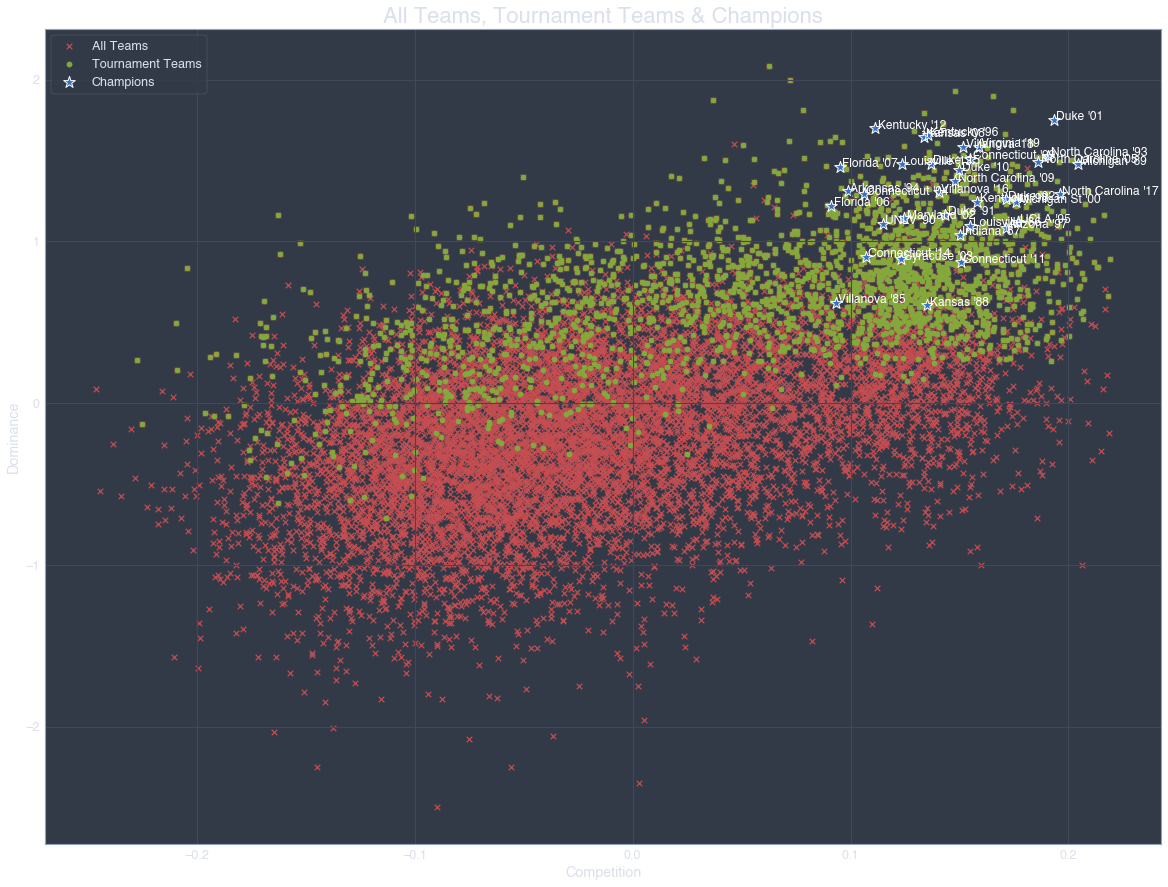

In [20]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["Competition"], summary_df["Dominance"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["Competition"], tournament_df["Dominance"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["Competition"], tournament_df[is_champion]["Dominance"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

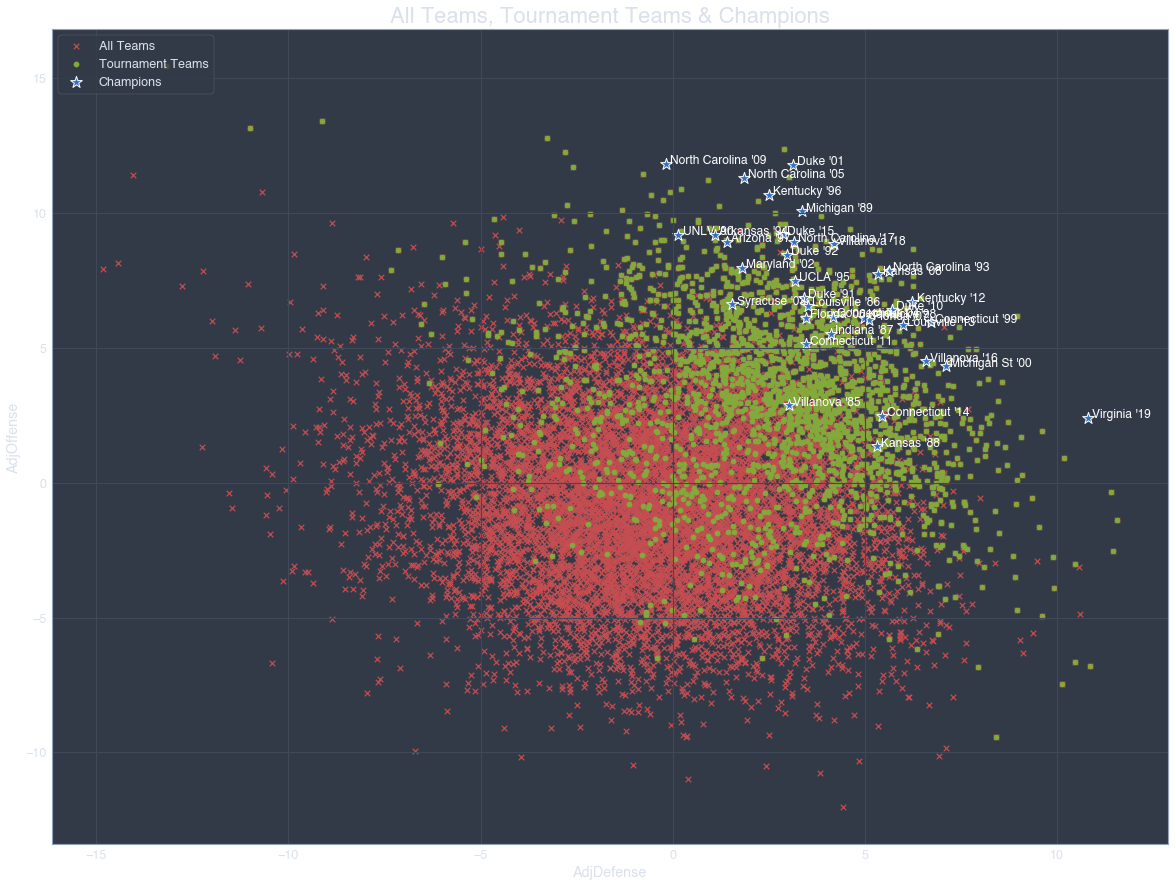

In [21]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["AdjDefense"], summary_df["AdjOffense"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["AdjDefense"], tournament_df["AdjOffense"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["AdjDefense"], tournament_df[is_champion]["AdjOffense"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

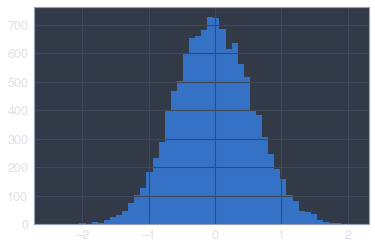

In [22]:
# Dominance follows a normal curve
plt.hist(summary_df["Dominance"], bins=50);

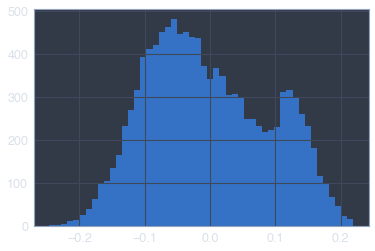

In [23]:
# Competition is a mix of two bell curves (one for elite teams and one for the rest)
plt.hist(summary_df["Competition"], bins=50);

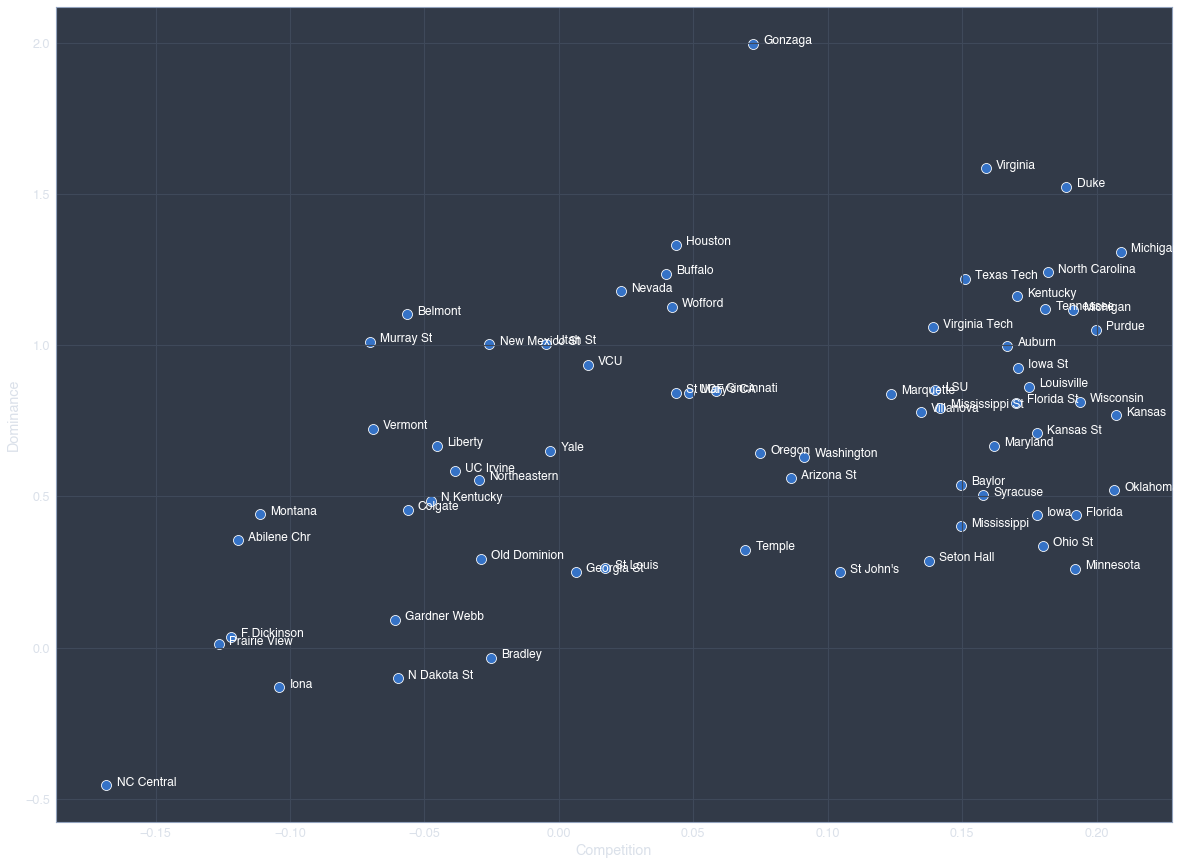

In [24]:
YEAR = 2019
is_year = tournament_df["Season"] == YEAR
plt.figure(figsize=(20,15));
scatter_text(
    x=tournament_df[is_year]["Competition"],
    y=tournament_df[is_year]["Dominance"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

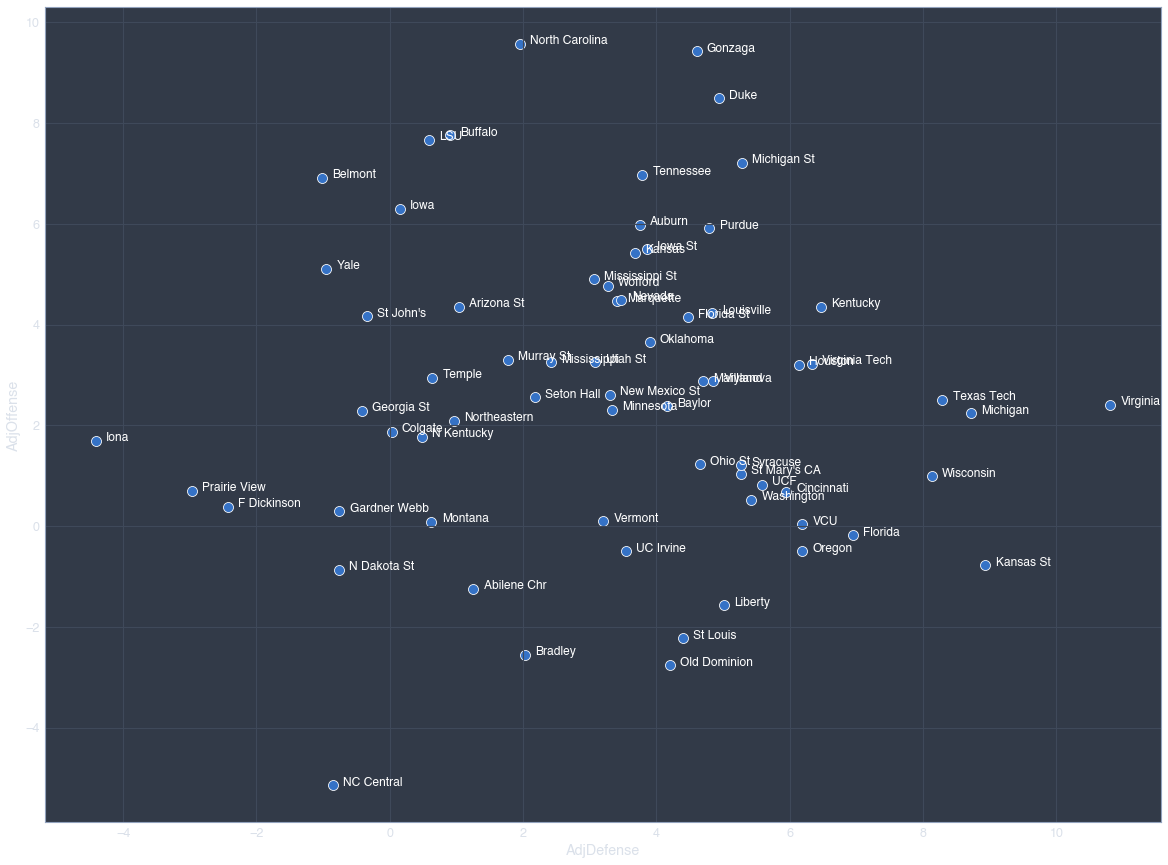

In [25]:
plt.figure(figsize=(20,15));
scatter_text(
    x=tournament_df[is_year]["AdjDefense"],
    y=tournament_df[is_year]["AdjOffense"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

In [26]:
# Top 25 Dominant teams
tournament_df.sort_values("Dominance", ascending=False)[:25]

,TeamID,TeamName,Season,OwnScore_Zscore,OppScore_Zscore,Dominance,OffCompetition,DefCompetition,Competition,AdjOffense,AdjDefense,Seed,SeedInt,Wins
1973,1424,UNLV,1991,1.650467,-0.434269,2.084736,0.051015,-0.011704,0.062719,11.355929,3.028745,Z01,1,4.0
612,1211,Gonzaga,2019,1.398097,-0.598454,1.996552,0.032873,-0.039467,0.072340,9.426596,4.602970,X01,1,3.0
838,1246,Kentucky,2015,0.743464,-1.188320,1.931784,0.074185,-0.073898,0.148082,6.196966,8.957689,Y01,1,4.0
419,1181,Duke,1999,1.691231,-0.207454,1.898685,0.089443,-0.076005,0.165448,12.380559,2.898834,W01,1,5.0
610,1211,Gonzaga,2017,1.066522,-0.804608,1.871130,0.001615,-0.035103,0.036718,6.742666,5.798284,X01,1,5.0
418,1181,Duke,1998,1.115641,-0.695448,1.811089,0.082741,-0.091634,0.174374,8.676690,6.245403,Z01,1,3.0
898,1257,Louisville,2014,1.078797,-0.731865,1.810663,0.039047,-0.039201,0.078249,7.570626,5.427473,Y04,4,2.0
822,1246,Kentucky,1997,1.220455,-0.570524,1.790978,0.047853,-0.085923,0.133776,8.625912,5.354632,Z01,1,5.0
421,1181,Duke,2001,1.473844,-0.278638,1.752481,0.127755,-0.065546,0.193301,11.802040,3.133246,W01,1,6.0
769,1242,Kansas,1997,1.361094,-0.362210,1.723304,0.067143,-0.075326,0.142469,9.885463,3.847875,X01,1,2.0


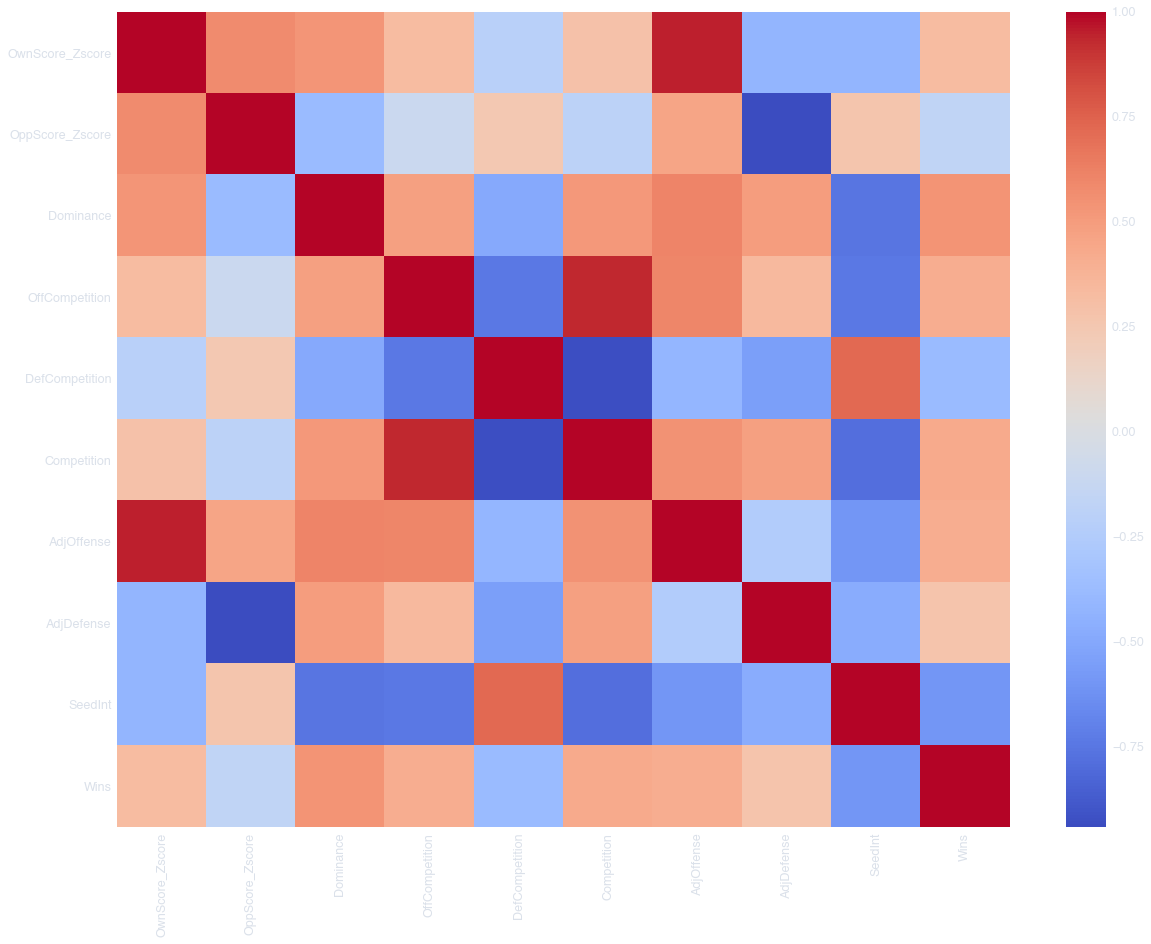

In [27]:
plt.figure(figsize=(20,15));
sns.heatmap(
    tournament_df.drop(["Season", "TeamID"], axis=1).corr(),
    cmap="coolwarm"
);

In [28]:
tournament_df.to_csv(f"{DATA_DIR}/output/teams.csv", index=False)

In [29]:
# Get game training data
should_use_all_games = True
merge_df = summary_df if should_use_all_games else tournament_df

# FEATURE_COLS = list(set(merge_df.columns) - {"Season", "TeamID"})
FEATURE_COLS = [
    "OwnScore_Zscore", "OppScore_Zscore",
    "OffCompetition", "DefCompetition",
    "AdjOffense", "AdjDefense"
]

def get_training_df(feature_cols):
    TOURNAMENT_COLS = ["Season", "TeamID"] + feature_cols

    training_df = reg_results_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "WTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"W{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df = training_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "LTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"L{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df["TeamID_A"] = training_df.apply(lambda x: min(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    training_df["TeamID_B"] = training_df.apply(lambda x: max(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    for col in tqdm(feature_cols):   
        training_df[f"{col}_A"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_A"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )
        training_df[f"{col}_B"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_B"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )

    training_df["Win_A"] = training_df["TeamID_A"] == training_df["WTeamID"]

    FINAL_COLS = (
        ["Season", "TeamID_A", "TeamID_B"] + 
        [f"{col}_A" for col in feature_cols] +
        [f"{col}_B" for col in feature_cols] +
        ["Win_A"]
    )
    training_df = training_df[FINAL_COLS]
    return training_df

training_df = get_training_df(FEATURE_COLS)
training_df

100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,OffCompetition_A,DefCompetition_A,AdjOffense_A,AdjDefense_A,OwnScore_Zscore_B,OppScore_Zscore_B,OffCompetition_B,DefCompetition_B,AdjOffense_B,AdjDefense_B,Win_A
0,1985,1228,1328,-0.170650,-1.122919,0.071527,-0.070089,0.475153,8.475028,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,True
1,1985,1228,1328,-0.170650,-1.122919,0.071527,-0.070089,0.475153,8.475028,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,True
2,1985,1242,1328,0.428736,-0.163805,0.075843,-0.034858,4.278642,1.807709,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,True
3,1985,1328,1374,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,0.522222,-0.193731,0.039361,-0.027919,4.125597,1.855630,False
4,1985,1328,1409,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,0.660810,0.046198,0.066972,-0.009949,5.539549,0.005346,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166875,2020,1460,1464,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,-0.105439,0.096059,-0.026838,0.058533,-1.096179,-1.668915,False
166876,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,-2.313324,0.157028,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,True
166877,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,-2.313324,0.157028,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,True
166878,2020,1232,1460,0.095964,-0.190164,-0.009144,-0.020654,0.508117,1.688731,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,True


In [30]:
training_df.to_csv(f"{DATA_DIR}/output/games_training.csv", index=False)